In [1]:
# 구현에 사용할 패키지 임포트하기
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

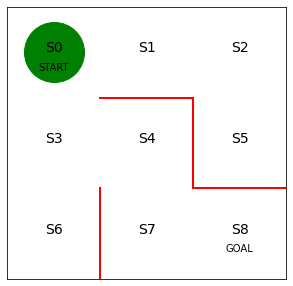

In [2]:
# 초기 상태의 미로 모습

# 전체 그림의 크기 및 그림을 나타내는 변수 선언
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 붉은 벽 그리기
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 상태를 의미하는 문자열(S0~S8) 표시
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 그림을 그릴 범위 및 눈금 제거 설정
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=False, right=False, left=False, labelleft=False)

# S0에 녹색 원으로 현재 위치를 표시
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

In [3]:
# 정책을 결정하는 파라미터의 초깃값 theta_0를 설정

# 줄은 상태 0~7, 열은 행동방향(상,우,하,좌 순)를 나타낸다
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8은 목표지점이므로 정책이 없다
                    ])

In [4]:
# 정책 파라미터 theta_0을 무작위 행동 정책 pi로 변환하는 함수

def simple_convert_into_pi_from_theta(theta):
    '''단순 비율 계산'''

    [m, n] = theta.shape  # theta의 행렬 크기를 구함
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])  # 비율 계산

    pi = np.nan_to_num(pi)  # nan을 0으로 변환

    return pi



In [5]:
# ε-greedy 알고리즘 구현
def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    # 행동을 결정
    if np.random.rand() < epsilon:
        # 확률 ε로 무작위 행동을 선택함
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # Q값이 최대가 되는 행동을 선택함
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 행동을 인덱스로 변환
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3

    return action


def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]  # 행동 a의 방향

    # 행동으로 다음 상태를 결정
    if next_direction == "up":
        s_next = s - 3  # 위로 이동하면 상태값이 3 줄어든다
    elif next_direction == "right":
        s_next = s + 1  # 오른쪽으로 이동하면 상태값이 1 늘어난다
    elif next_direction == "down":
        s_next = s + 3  # 아래로 이동하면 상태값이 3 늘어난다
    elif next_direction == "left":
        s_next = s - 1  # 왼쪽으로 이동하면 상태값이 1 줄어든다

    return s_next

In [6]:
# Sarsa 알고리즘으로 행동가치 함수 Q를 수정
def Sarsa(s, a, r, s_next, a_next, Q, eta, gamma):
    if s_next == 8:  # 목표 지점에 도달한 경우
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a])

    return Q


# Q러닝 알고리즘으로 행동가치 함수 Q를 수정
def Q_learning(s, a, r, s_next, Q, eta, gamma):
    if s_next == 8:  # 목표 지점에 도달한 경우
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next,: ]) - Q[s, a])

    return Q

In [12]:
# Sarsa 알고리즘으로 미로를 빠져나오는 함수, 상태 및 행동 그리고 Q값의 히스토리를 출력한다
def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0  # 시작 지점
    a = a_next = get_action(s, Q, epsilon, pi)  # 첫 번째 행동
    s_a_history = [[0, np.nan]]  # 에이전트의 행동 및 상태의 히스토리를 기록하는 리스트

    while (1):  # 목표 지점에 이를 때까지 반복
        a = a_next  # 행동 결정

        s_a_history[-1][1] = a
        # 현재 상태(마지막이므로 인덱스가 -1)을 히스토리에 추가

        s_next = get_s_next(s, a, Q, epsilon, pi)
        # 다음 단계의 상태를 구함

        s_a_history.append([s_next, np.nan])
        # 다음 상태를 히스토리에 추가, 행동은 아직 알 수 없으므로 nan으로 둔다

        # 보상을 부여하고 다음 행동을 계산함
        if s_next == 8:
            r = 1  # 목표 지점에 도달했다면 보상을 부여
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            # 다음 행동 a_next를 계산

        # 가치함수를 수정
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma)

        # 종료 여부 판정
        if s_next == 8:  # 목표 지점에 도달하면 종료
            break
        else:
            s = s_next

    return [s_a_history, Q]

In [13]:
# 무작위 행동정책 pi_0을 계산
pi_0 = simple_convert_into_pi_from_theta(theta_0)

# 행동가치 함수 Q의 초기 상태
[a, b] = theta_0.shape  # 열과 행의 갯수를 변수 a, b에 저장
Q = np.random.rand(a, b) * theta_0 * 0.1
# * theta0 로 요소 단위 곱셈을 수행, Q에서 벽 방향으로 이동하는 행동에는 nan을 부여

In [17]:
# Q러닝 알고리즘으로 미로 빠져나오기

eta = 0.1  # 학습률
gamma = 0.9  # 시간할인율
epsilon = 0.5  # ε-greedy 알고리즘 epsilon 초깃값
v = np.nanmax(Q, axis=1)  # 각 상태마다 가치의 최댓값을 계산
is_continue = True
episode = 1

V = []  # 에피소드 별로 상태가치를 저장
V.append(np.nanmax(Q, axis=1))  # 상태 별로 행동가치의 최댓값을 계산

while is_continue:  # is_continue의 값이 False가 될 때까지 반복
    print("에피소드: " + str(episode))

    # ε 값을 조금씩 감소시킴
    epsilon = epsilon / 2

    # Q러닝으로 미로를 빠져나온 후, 결과로 나온 행동 히스토리와 Q값을 변수에 저장
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    # 상태가치의 변화
    new_v = np.nanmax(Q, axis=1)  # 각 상태마다 행동가치의 최댓값을 계산
    print(np.sum(np.abs(new_v - v)))  # 상태가치 함수의 변화를 출력
    v = new_v
    V.append(v)  # 현재 에피소드가 끝난 시점의 상태가치 함수를 추가

    print("목표 지점에 이르기까지 걸린 단계 수는 " + str(len(s_a_history) - 1) + "단계입니다")

    # 100 에피소드 반복
    episode = episode + 1
    if episode > 100:
        break

에피소드: 1
0.06868200923998076
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
에피소드: 2
0.0004963800898555304
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
에피소드: 3
0.0004587624797449674
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
에피소드: 4
0.0004238989331916132
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
에피소드: 5
0.00039159695016721674
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
에피소드: 6
0.00036167661927322126
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
에피소드: 7
0.00033396987779688025
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
에피소드: 8
0.0003083198070218396
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
에피소드: 9
0.00028457996198127944
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
에피소드: 10
0.0002626137347573332
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
에피소드: 11
0.0002422937503501199
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
에피소드: 12
0.0002235012940908776
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
에피소드: 13
0.0002061257695213925
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
에피소드: 14
0.00019006418564226912
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
에피소드: 15
0.00017522067240272055
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
에피소드: 16
0.00016150602329922936
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
에피소드: 17
0.0001488372639502078
목표 지점에 이르기까지 

In [18]:
# 상태가치의 변화를 시각화
# 참고 URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm  # color map


def init():
    # 배경색 초기화
    line.set_data([], [])
    return (line,)


def animate(i):
    # 프레임 단위로 그림을 그림
    # 각 칸에 상태가치 값으로 결정된 색을 칠함
    line, = ax.plot([0.5], [2.5], marker="s",
                    color=cm.jet(V[i][0]), markersize=85)  # S0
    line, = ax.plot([1.5], [2.5], marker="s",
                    color=cm.jet(V[i][1]), markersize=85)  # S1
    line, = ax.plot([2.5], [2.5], marker="s",
                    color=cm.jet(V[i][2]), markersize=85)  # S2
    line, = ax.plot([0.5], [1.5], marker="s",
                    color=cm.jet(V[i][3]), markersize=85)  # S3
    line, = ax.plot([1.5], [1.5], marker="s",
                    color=cm.jet(V[i][4]), markersize=85)  # S4
    line, = ax.plot([2.5], [1.5], marker="s",
                    color=cm.jet(V[i][5]), markersize=85)  # S5
    line, = ax.plot([0.5], [0.5], marker="s",
                    color=cm.jet(V[i][6]), markersize=85)  # S6
    line, = ax.plot([1.5], [0.5], marker="s",
                    color=cm.jet(V[i][7]), markersize=85)  # S7
    line, = ax.plot([2.5], [0.5], marker="s",
                    color=cm.jet(1.0), markersize=85)  # S8
    return (line,)


# 초기화 함수와 프레임 단위로 그림을 그리는 함수로 애니메이션을 생성
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=len(V), interval=200, repeat=False)

HTML(anim.to_jshtml())